In [1]:
import numpy as np
import matplotlib.pylab as plt
import corner
import numdifftools as nd
import glob
import scipy.optimize as so
import scipy.linalg as sl
from PTMCMCSampler import PTMCMCSampler

%matplotlib inline

Do not have acor package


In [2]:
class GaussianLikelihood(object):
    
    def __init__(self, ndim=2, pmin=-10, pmax=10):
        
        self.a = np.ones(ndim)*pmin
        self.b = np.ones(ndim)*pmax
        
    def lnlikefn(self, x):
        return -0.5*np.sum(x**2)-len(x)*0.5*np.log(2*np.pi)
    
    def lnlikefn_grad(self, x):
        ll = -0.5*np.sum(x**2)-len(x)*0.5*np.log(2*np.pi)
        ll_grad = -x
        return ll, ll_grad
    
    def lnpriorfn(self, x):
        
        if np.all(self.a <= x) and np.all(self.b >= x):
            return 0.0
        else:
            return -np.inf  
        return 0.0
    
    def lnpriorfn_grad(self, x):
        return self.lnpriorfn(x), np.zeros_like(x)
    
    def lnpost_grad(self, x):
        ll, ll_grad = self.lnlikefn_grad(x)
        lp, lp_grad = self.lnpriorfn_grad(x)
        return ll+lp, ll_grad+lp_grad
    
    def lnpost(self, x):
        return self.lnpost_grad(x)[0]
    
    def hessian(self, x):
        return -np.eye(len(x))

In [3]:
class intervalTransform(object):
    """
    Wrapper class of the likelihood for Hamiltonian samplers. This implements a
    coordinate transformation for all parameters from an interval to all real numbers.
    """
    def __init__(self, likob, pmin=None, pmax=None):
        """Initialize the intervalLikelihood with a ptaLikelihood object"""
        self.likob = likob
        
        if pmin is None:
            self.a = likob.a
        else:
            self.a = pmin * np.ones_like(likob.a)
        
        if pmax is None:
            self.b = likob.b
        else:
            self.b = pmax * np.ones_like(likob.b)

    def forward(self, x):
        """Forward transform the real coordinates (on the interval) to the
        transformed coordinates (on all real numbers)
        """
        p = np.atleast_2d(x.copy())
        posinf, neginf = (self.a == x), (self.b == x)
        m = ~(posinf | neginf)
        p[:,m] = np.log((p[:,m] - self.a[m]) / (self.b[m] - p[:,m]))
        p[:,posinf] = np.inf
        p[:,neginf] = -np.inf
        return p.reshape(x.shape)

    def backward(self, p):
        """Backward transform the transformed coordinates (on all real numbers)
        to the real coordinates (on the interval)
        """
        x = np.atleast_2d(p.copy())
        x[:,:] = (self.b[:] - self.a[:]) * np.exp(x[:,:]) / (1 +
                np.exp(x[:,:])) + self.a[:]
        return x.reshape(p.shape)
    
    def logjacobian_grad(self, p):
        """Return the log of the Jacobian at point p"""
        lj = np.sum( np.log(self.b[:]-self.a[:]) + p[:] -
                2*np.log(1.0+np.exp(p[:])) )

        lj_grad = np.zeros_like(p)
        lj_grad[:] = (1 - np.exp(p[:])) / (1 + np.exp(p[:]))
        return lj, lj_grad

    def dxdp(self, p):
        """Derivative of x wrt p (jacobian for chain-rule) - diagonal"""
        pp = np.atleast_2d(p)
        d = np.ones_like(pp)
        d[:,:] = (self.b[:]-self.a[:])*np.exp(pp[:,:])/(1+np.exp(pp[:,:]))**2
        return d.reshape(p.shape)

    def d2xd2p(self, p):
        """Derivative of x wrt p (jacobian for chain-rule) - diagonal"""
        pp = np.atleast_2d(p)
        d = np.zeros_like(pp)
        d[:,:] = (self.b[:]-self.a[:])*(np.exp(2*pp[:,:])-np.exp(pp[:,:]))/(1+np.exp(pp[:,:]))**3
        return d.reshape(p.shape)

    def logjac_hessian(self, p):
        """The Hessian of the log-jacobian"""
        # p should not be more than one-dimensional
        assert len(p.shape) == 1

        return np.diag(-2*np.exp(p) / (1+np.exp(p))**2)

    def lnlikefn_grad(self, p, **kwargs):
        """The log-likelihood in the new coordinates"""
        x = self.backward(p)
        ll, ll_grad = self.likob.lnlikefn_grad(x, **kwargs)
        lj, lj_grad = self.logjacobian_grad(p)
        return ll+lj, ll_grad*self.dxdp(p)+lj_grad
    
    def lnlikefn(self, p, **kwargs):
        return self.lnlikefn_grad(p)[0]

    def lnpriorfn_grad(self, p, **kwargs):
        """The log-prior in the new coordinates. Do not include the Jacobian"""
        x = self.backward(p)
        lp, lp_grad = self.likob.lnpriorfn_grad(x)
        return lp, lp_grad*self.dxdp(p)
    
    def lnpriorfn(self, p, **kwargs):
        return self.lnpriorfn_grad(p)[0]

    def logpostfn_grad(self, p, **kwargs):
        """The log-posterior in the new coordinates"""
        x = self.backward(p)
        lp, lp_grad = self.likob.lnpost_grad(x)
        lj, lj_grad = self.logjacobian_grad(p)
        return lp+lj, lp_grad*self.dxdp(p)+lj_grad


    def hessian(self, p):
        """The Hessian matrix in the new coordinates"""
        # p should not be more than one-dimensional
        assert len(p.shape) == 1

        # Get quantities from un-transformed distribution
        x = self.backward(p)
        orig_hessian = self.likob.hessian(x)
        _, orig_lp_grad = self.likob.lnpost_grad(x)

        # Transformation properties
        hessian = self.logjac_hessian(p)
        dxdpf = np.diag(self.dxdp(p))

        hessian += np.dot(dxdpf.T, np.dot(orig_hessian, dxdpf))
        hessian -= np.diag(self.d2xd2p(p)*orig_lp_grad)

        return hessian


In [4]:
ndim = 40
glo = GaussianLikelihood(ndim=ndim, pmin=0.0, pmax=10.0)
glt = intervalTransform(glo, pmin=0.0, pmax=10)
gl = glt

In [6]:
# Demonstrate that the gradients are accurate
p0 = np.ones(ndim)*0.01
ndjac = nd.Jacobian(gl.lnlikefn)
ndhes = nd.Hessian(gl.lnlikefn)
ndhesd = nd.Hessdiag(gl.lnlikefn)

print(p0[:4])
print(gl.lnlikefn_grad(p0)[1][:4])
print(ndjac(p0)[:4])
print(np.diag(gl.hessian(p0))[:4])
print(ndhesd(p0)[:4])

[0.01 0.01 0.01 0.01]
[-12.56718538 -12.56718538 -12.56718538 -12.56718538]
[[-12.56718538 -12.56718538 -12.56718538 -12.56718538 -12.56718538
  -12.56718538 -12.56718538 -12.56718538 -12.56718538 -12.56718538
  -12.56718538 -12.56718538 -12.56718538 -12.56718538 -12.56718538
  -12.56718538 -12.56718538 -12.56718538 -12.56718538 -12.56718538
  -12.56718538 -12.56718538 -12.56718538 -12.56718538 -12.56718538
  -12.56718538 -12.56718538 -12.56718538 -12.56718538 -12.56718538
  -12.56718538 -12.56718538 -12.56718538 -12.56718538 -12.56718538
  -12.56718538 -12.56718538 -12.56718538 -12.56718538 -12.56718538]]
[-6.68686461 -6.68686461 -6.68686461 -6.68686461]
[-6.68686461 -6.68686461 -6.68686461 -6.68686461]


In [7]:
# Maximize using scipy
result = so.minimize(lambda x: -gl.lnlikefn(x), p0, jac=lambda x: -gl.lnlikefn_grad(x)[1],
                     method='Newton-CG', hess=lambda x: -gl.hessian(x), options={'disp':True})

Optimization terminated successfully.
         Current function value: 60.851504
         Iterations: 6
         Function evaluations: 6
         Gradient evaluations: 6
         Hessian evaluations: 6


In [9]:
# Set the start position and the covariance
p0 = result['x']
h0 = gl.hessian(p0)
cov = sl.cho_solve(sl.cho_factor(-h0), np.eye(len(h0)))
print(np.diag(cov)[:10])

[0.63993025 0.63993025 0.63993025 0.63993025 0.63993025 0.63993025
 0.63993025 0.63993025 0.63993025 0.63993025]


In [10]:
sampler = PTMCMCSampler.PTSampler(ndim, gl.lnlikefn, gl.lnpriorfn, np.copy(cov),
                                  logl_grad=gl.lnlikefn_grad, logp_grad=gl.lnpriorfn_grad,
                                  outDir='./chains')

In [11]:
sampler.sample(p0, 60000, burn=500, thin=1, covUpdate=500,
               SCAMweight=10, AMweight=10, DEweight=10, NUTSweight=10, HMCweight=10, MALAweight=0,
               HMCsteps=100, HMCstepsize=0.4)

Adding DE jump with weight 10
Finished 98.33 percent in 64.905512 s Acceptance rate = 0.523271
Run Complete


(0.0, 1.1)

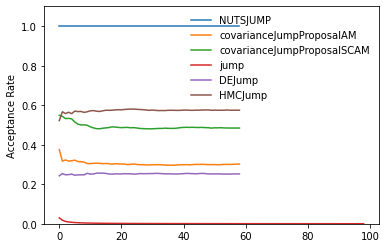

In [12]:
jumpfiles = glob.glob('chains/*jump.txt')
jumps = map(np.loadtxt, jumpfiles)
for ct, j in enumerate(jumps):
    plt.plot(j, label=jumpfiles[ct].split('/')[-1].split('_jump.txt')[0])
plt.legend(loc='best', frameon=False)
plt.ylabel('Acceptance Rate')
plt.ylim(0.0, 1.1)

In [13]:
data = np.loadtxt('chains/chain_1.txt')
chaint = data[:,:-4]

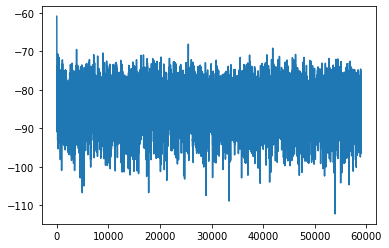

In [14]:
plt.plot(data[0:,-4])

In [15]:
chain = glt.backward(chaint)

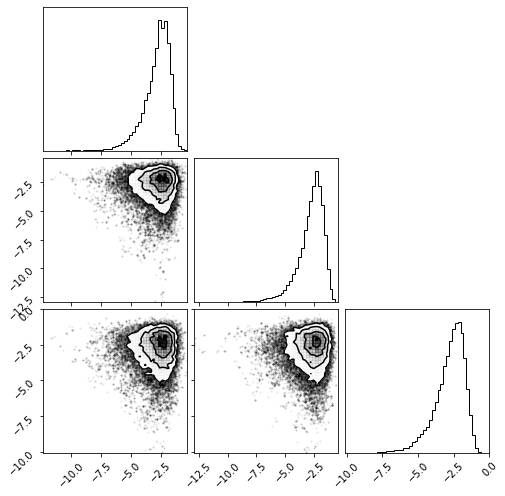

In [16]:
corner.corner(chaint[:,:3], bins=50);

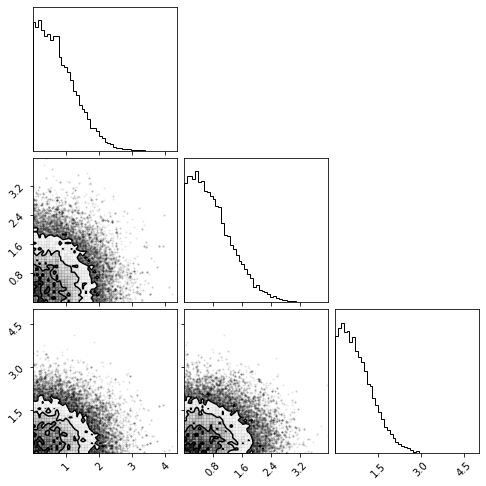

In [17]:
corner.corner(chain[:,:3], bins=50);